Sergio Adrian Martínez Tena

# Bibliotecas necesarias

In [1]:
from AC import specialGreen,specialPurple,specialRed,createFigures
from sklearn.decomposition import PCA as pcaSklearn
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
# Define color map to use
cmap = plt.get_cmap('Dark2',3)

# Función para obtener los componentes principales

In [2]:
def PCA(data:'Numpy array or Pandas DataFrame', k:'First principal components'=2, 
        plotRanking=False, frame=False, showPCs=False):
    # k = 'all' means using all principal components
    if k == 'all':
        k = data.shape[1]
    # Calculate the covariance matrix
    cov = np.cov(data, rowvar=False)
    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    eigenvalues = eigenvalues/eigenvalues.sum()
    # Make ranking with eigenvalues
    rank = sorted(range(eigenvalues.size), key=lambda k: eigenvalues[k], reverse=True)
    # Sort arrays by the rank
    eigenvalues = eigenvalues[rank]
    eigenvectors =  eigenvectors[:,rank]
    # If the flag is true plot every principal component
    if plotRanking:
        # Plot the the ranking of every vector k
        ax = createFigures(figsize=(18,5))
        pcs = eigenvalues[:k]
        n = pcs.size
        ax.bar(range(n), pcs, color=specialGreen, alpha=0.5, label='Explained Variance of $PC_i$');
        cdf = np.cumsum(pcs)
        # If the flag is True show the other components on the graph
        if showPCs:
            n = eigenvalues.size
            zeros = np.zeros((k))
            ax.bar(range(n), np.concatenate((zeros,eigenvalues[k:])), color=specialPurple, alpha=0.5);
        if n < 15:
            ax.set_xticks(range(n), labels=[f'$PC_{{{i+1}}}$' for i in range(n)])
            ax.plot(range(cdf.size), cdf, 'o-', color=specialRed, label=f'Cumulative Variance: {round(pcs.sum(),3)}');
        else:
            ax.plot(range(cdf.size), cdf, '-', color=specialRed, label=f'Cumulative Variance: {round(pcs.sum(),3)}');
        ax.set_ylabel('Portion of Variance');
        ax.set_xlabel('Principal Components');
        ax.set_title('Explained variance as a function of the number of dimensions', fontsize=16, fontweight='bold')
        ax.legend(fontsize=14)
    # Matrix containing the first k principal components  
    w = eigenvectors[:,:k]
    # Projecting the data set down to d dimensions 
    dataProj = np.dot(data,w)
    # Return a new DataFrame projected into the first k principal components if frame is True
    if frame:
        return pd.DataFrame(dataProj, columns=[f'PC{i+1}' for i in range(k)]), w  
    else:
        return dataProj, w

# Resultados

## Se importa la imagem a utilizar

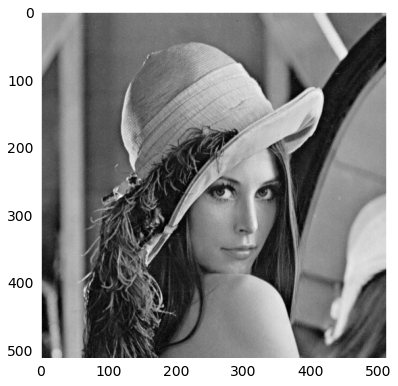

In [3]:
image = np.asarray(Image.open('lena_grey.jpg').convert("L"), dtype='float64')
ax = createFigures()
ax.imshow(image, cmap='gray');
ax.grid(False)

Tamaño de la matriz de datos.

In [4]:
image.shape

(512, 512)

## Compresión de la image

Se estandalizan los datos

In [5]:
mean = image.mean(axis=0)
std = image.std(axis=0)
imageStd = (image - mean)/std

Se obtienen los primeros 50 componentes principales (comprimiendo los datos)

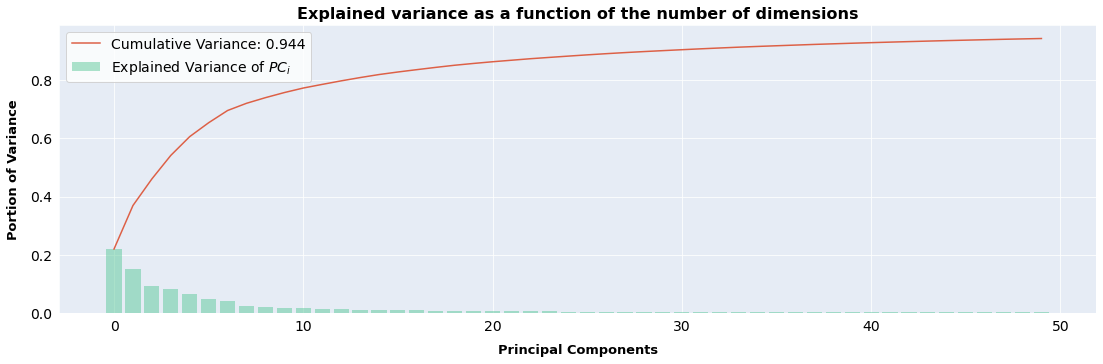

In [6]:
imageProj, w = PCA(imageStd,k=50, plotRanking=True, showPCs=False)

Nuevo tamaño de la matriz de datos.

In [7]:
imageProj.shape

(512, 50)

Se obtiene la imagen aproximada utilizando la matriz de transformación w. 

In [8]:
imageAprox = np.dot(imageProj,w.T)
imageAprox.shape

(512, 512)

Se muestra la imagen aproximada.

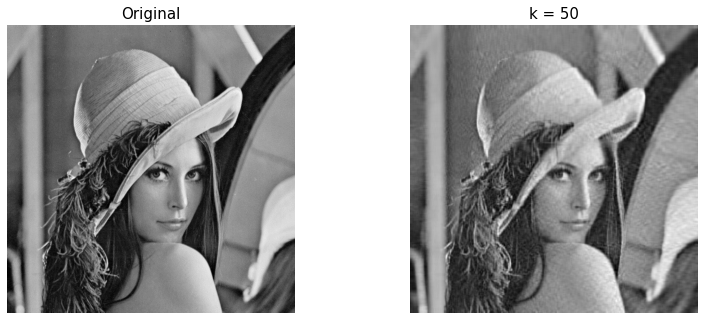

In [9]:
imageAprox = imageAprox*std + mean
ax1, ax2 = createFigures(n_axes=2)
ax1.imshow(image, cmap='gray');
ax1.grid(False)
ax1.axis('off');
ax1.set_title('Original', fontsize=15)
ax2.imshow(imageAprox, cmap='gray')
ax2.grid(False)
ax2.set_title(f'k = {50}', fontsize=15)
ax2.axis('off');

Para calcular el error cuadrático medio se compara la diferencia entre el valor de los píxeles entre la imagen original y la imagen aproximada, para este punto se utilizó la función $mean_squared_error$ de la biblioteca scikit-learn.

In [10]:
# Calculate the MSE
mse = mean_squared_error(image.ravel(),imageAprox.ravel())
mse

73.80961318699707

Para calcular el porcentaje de compresión se comparan los valores necesarios para almacenar las imágenes.

In [11]:
# Valores necesarios para almacenar la imagen original
oldSize = image.size
oldSize

262144

In [12]:
# Valores necesarios para almacenar la imagen aproximada
# Valores de la imagen proyectada y valores de la matriz de transformacion
newSize = imageProj.size + w.size
newSize

51200

In [13]:
# Razon de compresión
pCompresion = ((oldSize-newSize)/oldSize)*100
print(f'{pCompresion}%')

80.46875%


## Varios valores de k

Se realizan los pasos anteriores para K = 85, 170, 255, 340, 425 y 510

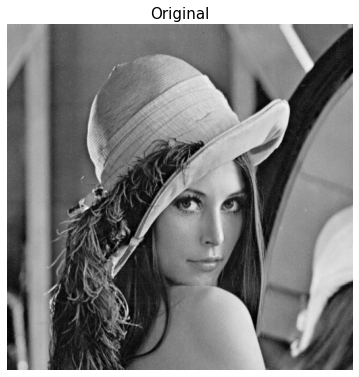

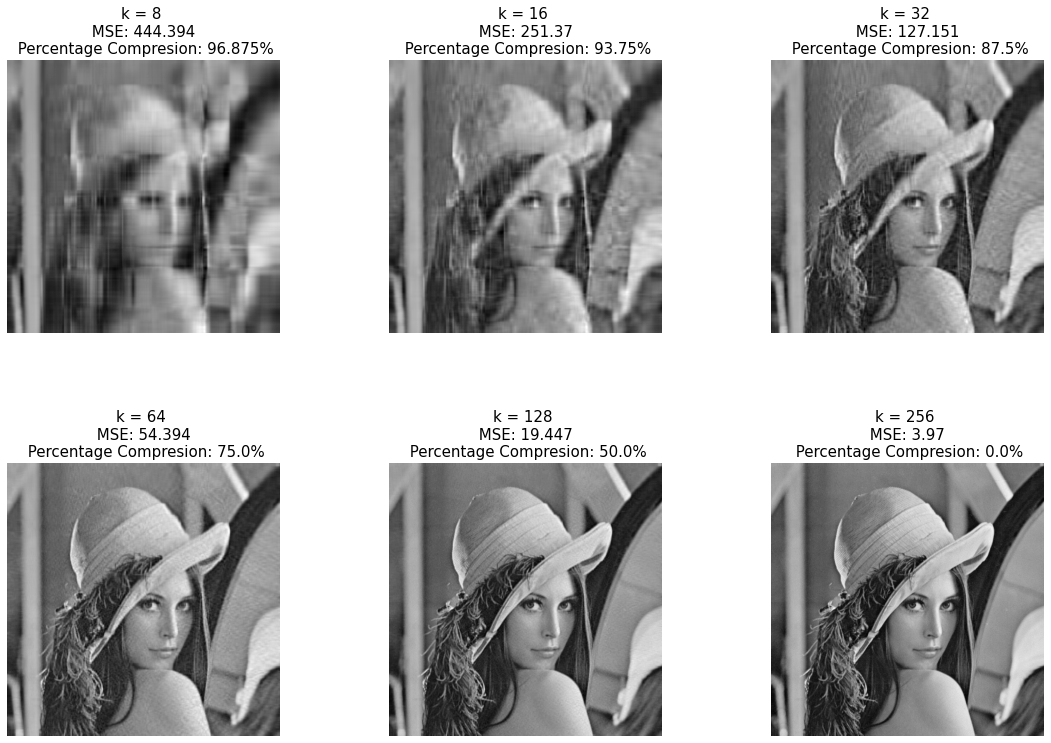

In [14]:
# Show the original image
ax = createFigures()
ax.imshow(image, cmap='gray');
ax.grid(False)
ax.axis('off');
ax.set_title('Original', fontsize=15)
# k values
Ks = [8, 16, 32, 64, 128, 256]
# Create figures
axes = createFigures(n_axes=len(Ks), columns=3)

oldSize = image.size
# For every K make all the process
for i, k in enumerate(Ks):
    # Get the k principal components
    newImage, w = PCA(imageStd, k=k)
    newSize = newImage.size + w.size
    pCompresion = round(((oldSize-newSize)/oldSize)*100,3)
    # Aproximate the image using the matrix transformation w
    imageAprox = np.dot(newImage,w.T)
    imageAprox = imageAprox*std + mean
    # Calculate the MSE
    mse = mean_squared_error(image.ravel(),imageAprox.ravel())
    # Plot the new image
    axes[i].imshow(imageAprox, cmap='gray');
    axes[i].grid(False)
    axes[i].axis('off');
    axes[i].set_title(f'k = {k} \n MSE: {round(mse,3)} \n Percentage Compresion: {pCompresion}%', fontsize=15)